---
**Autores**: Prof. João Nogueira e Prof. Dino Magri

**Contato**: `joaonogueira@fisica.ufc.br` e `professor.dinomagri@gmail.com`

**Licença deste notebook**: 
<br>
<img align="left" width="80" src="https://licensebuttons.net/l/by/3.0/88x31.png" />

<br>
<br>

[Clique aqui para saber mais sobre a licença CC BY v4.0](https://creativecommons.org/licenses/by/4.0/legalcode.pt)


---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# !pip install yellowbrick==1.1

In [ ]:
import numpy as np
import pandas as pd

# Carregando os Dados

In [ ]:
df_orders = pd.read_csv('/content/drive/MyDrive/datasets/olist/input/olist_orders_dataset.csv')
df_order_items = pd.read_csv('/content/drive/MyDrive/datasets/olist/input/olist_order_items_dataset.csv')
df_products = pd.read_csv('/content/drive/MyDrive/datasets/olist/input/olist_products_dataset.csv')

In [ ]:
df_orders.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


In [ ]:
df_order_items.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87


In [ ]:
df_products.head(3)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0


# Clusterizando por Categorias: Criando a ABT

In [ ]:
# join da tabela de items com a tabela de produtos
df_joined = df_order_items.merge(df_products, how='inner', on='product_id')

In [ ]:
# pivoteando a tabela para saber a quantidade percentual dentro de cada categoria que cada seller vendeu
df_abt_categorias = pd.crosstab(df_joined['seller_id'], df_joined['product_category_name'], normalize='index').reset_index()

In [ ]:
# retirando o eixo indesejado
df_abt_categorias = df_abt_categorias.rename_axis(None, axis = 1)

In [ ]:
df_abt_categorias

,seller_id,agro_industria_e_comercio,alimentos,alimentos_bebidas,artes,artes_e_artesanato,artigos_de_festas,artigos_de_natal,audio,automotivo,bebes,bebidas,beleza_saude,brinquedos,cama_mesa_banho,casa_conforto,casa_conforto_2,casa_construcao,cds_dvds_musicais,cine_foto,climatizacao,consoles_games,construcao_ferramentas_construcao,construcao_ferramentas_ferramentas,construcao_ferramentas_iluminacao,construcao_ferramentas_jardim,construcao_ferramentas_seguranca,cool_stuff,dvds_blu_ray,eletrodomesticos,eletrodomesticos_2,eletronicos,eletroportateis,esporte_lazer,fashion_bolsas_e_acessorios,fashion_calcados,fashion_esporte,fashion_roupa_feminina,fashion_roupa_infanto_juvenil,fashion_roupa_masculina,fashion_underwear_e_moda_praia,ferramentas_jardim,flores,fraldas_higiene,industria_comercio_e_negocios,informatica_acessorios,instrumentos_musicais,la_cuisine,livros_importados,livros_interesse_geral,livros_tecnicos,malas_acessorios,market_place,moveis_colchao_e_estofado,moveis_cozinha_area_de_servico_jantar_e_jardim,moveis_decoracao,moveis_escritorio,moveis_quarto,moveis_sala,musica,papelaria,pc_gamer,pcs,perfumaria,pet_shop,portateis_casa_forno_e_cafe,portateis_cozinha_e_preparadores_de_alimentos,relogios_presentes,seguros_e_servicos,sinalizacao_e_seguranca,tablets_impressao_imagem,telefonia,telefonia_fixa,utilidades_domesticas
0,0015a82c2db000af6aaaf3ae2ecb0532,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,001cca7ae9ae17fb1caed9dfb1094831,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.112971,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.887029,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,001e6ad469a905060d959994f1b41e4f,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,002100f778ceb8431b7a1020ff7ab48f,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,004c9cd9d87a3c30c522c48c4fc07416,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3030,ffcfefa19b08742c5d315f2791395ee5,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3031,ffdd9f82b9a447f6f8d4b91554cc7dd3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [ ]:
X_abt_categorias = df_abt_categorias.drop(columns=['seller_id']).copy()
X_abt_categorias.head()

,agro_industria_e_comercio,alimentos,alimentos_bebidas,artes,artes_e_artesanato,artigos_de_festas,artigos_de_natal,audio,automotivo,bebes,bebidas,beleza_saude,brinquedos,cama_mesa_banho,casa_conforto,casa_conforto_2,casa_construcao,cds_dvds_musicais,cine_foto,climatizacao,consoles_games,construcao_ferramentas_construcao,construcao_ferramentas_ferramentas,construcao_ferramentas_iluminacao,construcao_ferramentas_jardim,construcao_ferramentas_seguranca,cool_stuff,dvds_blu_ray,eletrodomesticos,eletrodomesticos_2,eletronicos,eletroportateis,esporte_lazer,fashion_bolsas_e_acessorios,fashion_calcados,fashion_esporte,fashion_roupa_feminina,fashion_roupa_infanto_juvenil,fashion_roupa_masculina,fashion_underwear_e_moda_praia,ferramentas_jardim,flores,fraldas_higiene,industria_comercio_e_negocios,informatica_acessorios,instrumentos_musicais,la_cuisine,livros_importados,livros_interesse_geral,livros_tecnicos,malas_acessorios,market_place,moveis_colchao_e_estofado,moveis_cozinha_area_de_servico_jantar_e_jardim,moveis_decoracao,moveis_escritorio,moveis_quarto,moveis_sala,musica,papelaria,pc_gamer,pcs,perfumaria,pet_shop,portateis_casa_forno_e_cafe,portateis_cozinha_e_preparadores_de_alimentos,relogios_presentes,seguros_e_servicos,sinalizacao_e_seguranca,tablets_impressao_imagem,telefonia,telefonia_fixa,utilidades_domesticas
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.112971,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.887029,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Clustering com KMeans

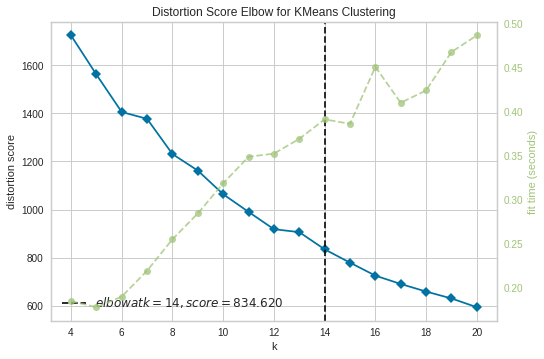

In [ ]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

kmeans = KMeans(random_state=29)
visualizer = KElbowVisualizer(kmeans, k=(4, 21))
visualizer.fit(X_abt_categorias)
visualizer.show()

In [ ]:
kmeans = KMeans(n_clusters=14, random_state=15)
kmeans.fit(X_abt_categorias)
df_abt_categorias['cluster_id'] = kmeans.labels_ # kmeans.predict(X_abt_categorias)

In [ ]:
df_abt_categorias.head()

,seller_id,agro_industria_e_comercio,alimentos,alimentos_bebidas,artes,artes_e_artesanato,artigos_de_festas,artigos_de_natal,audio,automotivo,bebes,bebidas,beleza_saude,brinquedos,cama_mesa_banho,casa_conforto,casa_conforto_2,casa_construcao,cds_dvds_musicais,cine_foto,climatizacao,consoles_games,construcao_ferramentas_construcao,construcao_ferramentas_ferramentas,construcao_ferramentas_iluminacao,construcao_ferramentas_jardim,construcao_ferramentas_seguranca,cool_stuff,dvds_blu_ray,eletrodomesticos,eletrodomesticos_2,eletronicos,eletroportateis,esporte_lazer,fashion_bolsas_e_acessorios,fashion_calcados,fashion_esporte,fashion_roupa_feminina,fashion_roupa_infanto_juvenil,fashion_roupa_masculina,fashion_underwear_e_moda_praia,ferramentas_jardim,flores,fraldas_higiene,industria_comercio_e_negocios,informatica_acessorios,instrumentos_musicais,la_cuisine,livros_importados,livros_interesse_geral,livros_tecnicos,malas_acessorios,market_place,moveis_colchao_e_estofado,moveis_cozinha_area_de_servico_jantar_e_jardim,moveis_decoracao,moveis_escritorio,moveis_quarto,moveis_sala,musica,papelaria,pc_gamer,pcs,perfumaria,pet_shop,portateis_casa_forno_e_cafe,portateis_cozinha_e_preparadores_de_alimentos,relogios_presentes,seguros_e_servicos,sinalizacao_e_seguranca,tablets_impressao_imagem,telefonia,telefonia_fixa,utilidades_domesticas,cluster_id
0,0015a82c2db000af6aaaf3ae2ecb0532,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
1,001cca7ae9ae17fb1caed9dfb1094831,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.112971,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.887029,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
2,001e6ad469a905060d959994f1b41e4f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
3,002100f778ceb8431b7a1020ff7ab48f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11
4,004c9cd9d87a3c30c522c48c4fc07416,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6


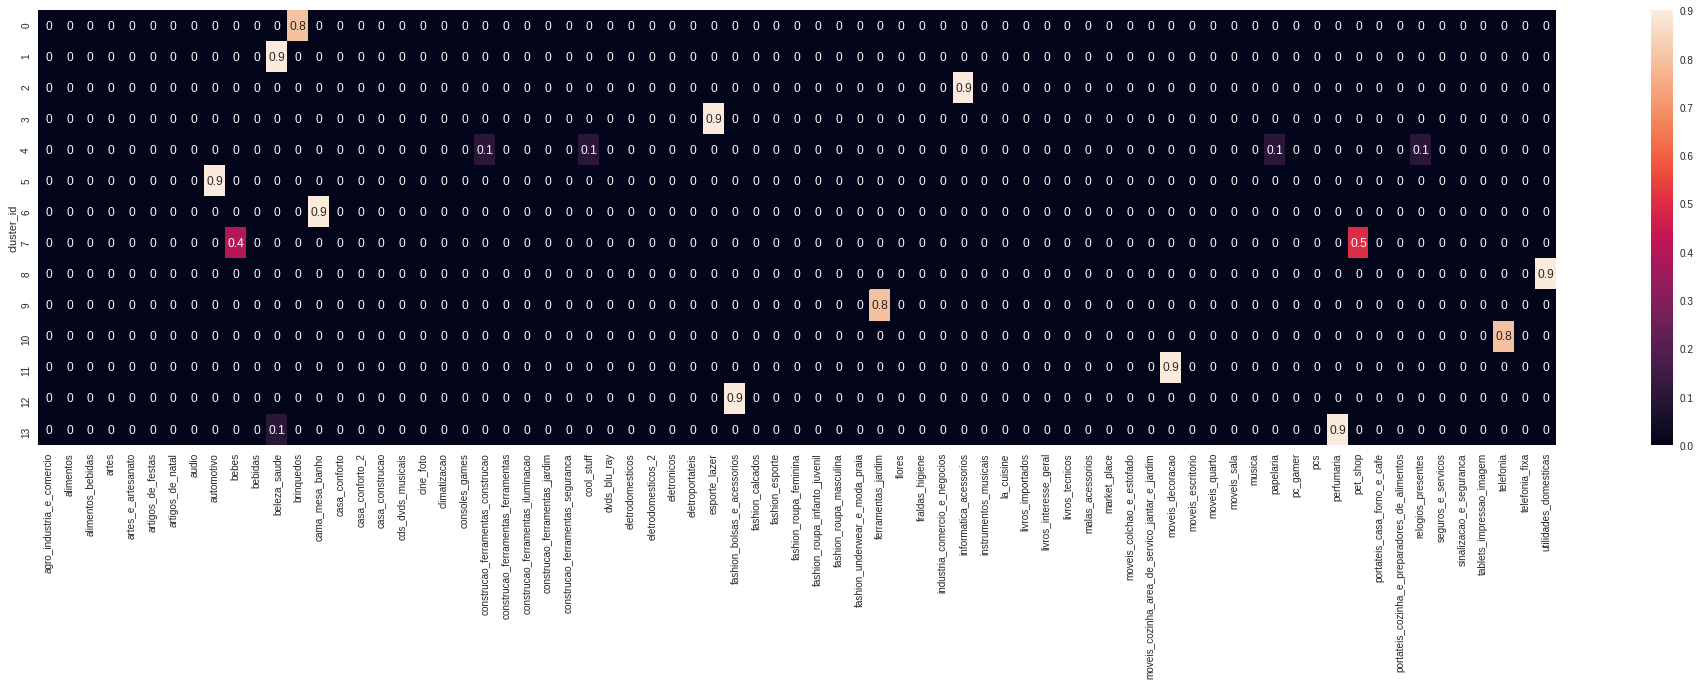

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(34, 8))

tabulacao = X_abt_categorias.groupby(df_abt_categorias['cluster_id']).mean().round(1)

sns.heatmap(tabulacao, annot=True);

# Surrougate Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()
tree.fit(X_abt_categorias, df_abt_categorias['cluster_id'])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
top_features = pd.Series(tree.feature_importances_, index=X_abt_categorias.columns.tolist()).sort_values(ascending=False).head(14).index.tolist()

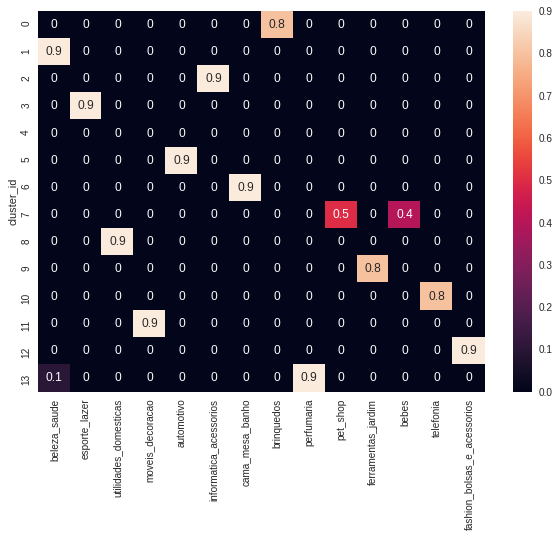

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))

sns.heatmap(X_abt_categorias.groupby(df_abt_categorias['cluster_id'])[top_features].mean().round(1), annot=True);

# Clusterização por Frequência versus Receita

In [ ]:
df_abt_fv = (
    df_order_items
    .merge(df_orders, on='order_id', how='left')
    .filter(['order_id', 'seller_id', 'price'])
    .groupby('seller_id')
    .agg(
        receita = ('price', 'sum'),
        vendas = ('order_id', 'nunique')
    ).reset_index())

df_abt_fv.head()

,seller_id,receita,vendas
0,0015a82c2db000af6aaaf3ae2ecb0532,2685.00,3
1,001cca7ae9ae17fb1caed9dfb1094831,25080.03,200
2,001e6ad469a905060d959994f1b41e4f,250.00,1
3,002100f778ceb8431b7a1020ff7ab48f,1234.50,51
4,003554e2dce176b5555353e4f3555ac8,120.00,1


In [ ]:
df_abt_fv['rank_pct_receita'] = df_abt_fv['receita'].rank(pct=True)
df_abt_fv['rank_pct_vendas'] = df_abt_fv['vendas'].rank(pct=True)

In [ ]:
df_abt_fv.head()

,seller_id,receita,vendas,rank_pct_receita,rank_pct_vendas
0,0015a82c2db000af6aaaf3ae2ecb0532,2685.00,3,0.716640,0.334249
1,001cca7ae9ae17fb1caed9dfb1094831,25080.03,200,0.967690,0.971082
2,001e6ad469a905060d959994f1b41e4f,250.00,1,0.276252,0.092407
3,002100f778ceb8431b7a1020ff7ab48f,1234.50,51,0.580937,0.865267
4,003554e2dce176b5555353e4f3555ac8,120.00,1,0.156220,0.092407


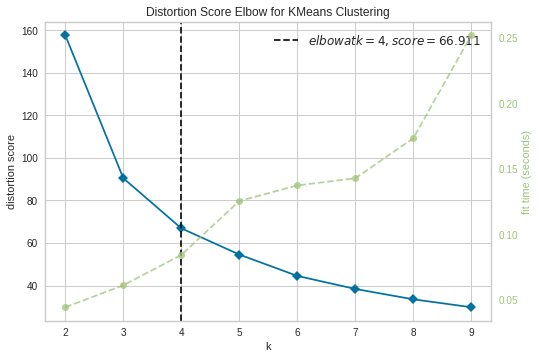

In [ ]:
X_abt_fv = df_abt_fv[['rank_pct_receita', 'rank_pct_vendas']].copy()

kmeans = KMeans(random_state=29)
visualizer = KElbowVisualizer(kmeans, k=(2, 10))
visualizer.fit(X_abt_fv)
visualizer.show();

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=1234)
kmeans.fit(X_abt_fv)
df_abt_fv['cluster_id'] = kmeans.labels_

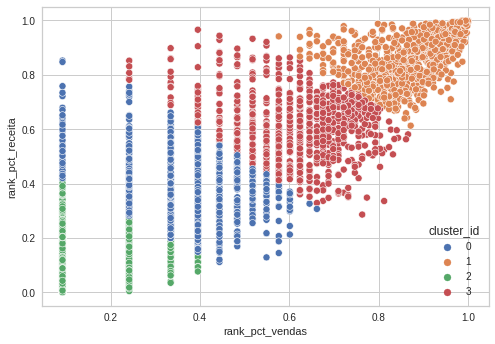

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(data=df_abt_fv, x='rank_pct_vendas', y='rank_pct_receita', hue='cluster_id', s=50, palette='deep');

# Juntando tudo!

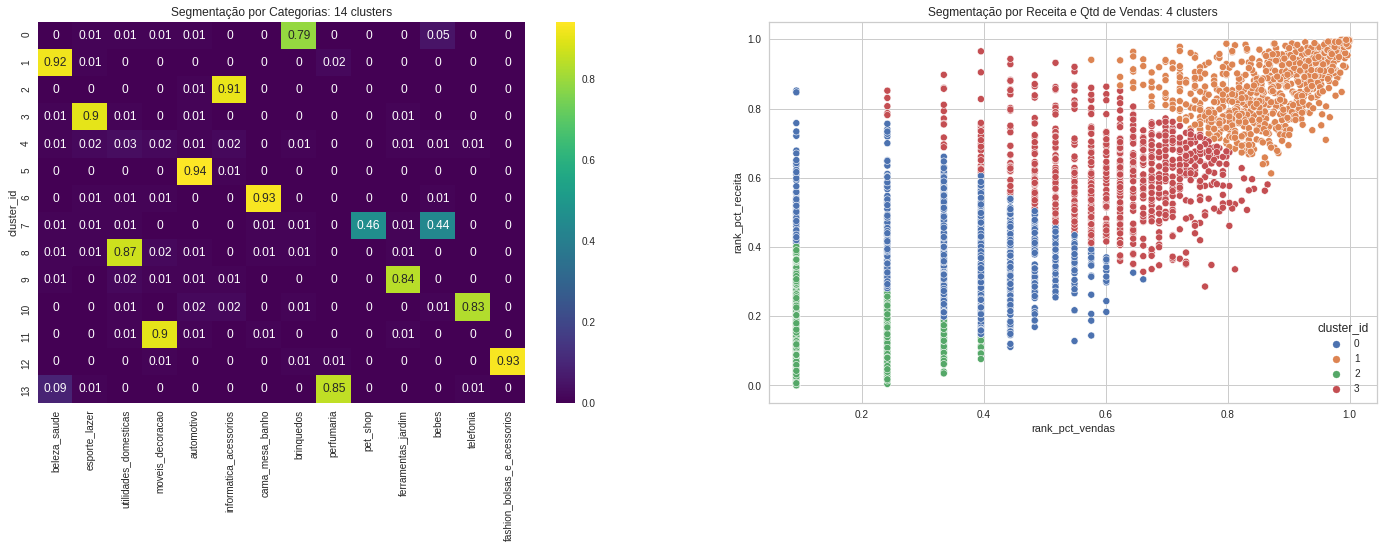

In [ ]:
fig, ax = plt.subplots(figsize=(24, 7), nrows=1, ncols=2)

ax[0].set_title('Segmentação por Categorias: 14 clusters');
sns.heatmap(X_abt_categorias.groupby(df_abt_categorias['cluster_id'])[top_features].mean().round(2), ax=ax[0], cmap='viridis', annot=True);
ax[1].set_title('Segmentação por Receita e Qtd de Vendas: 4 clusters');
sns.scatterplot(data=df_abt_fv, x='rank_pct_vendas', y='rank_pct_receita', hue='cluster_id', s=50, palette='deep', ax=ax[1]);

In [ ]:
df_clusters = (
    df_abt_categorias
    .merge(df_abt_fv, on='seller_id', how='left')
    .rename(columns={'cluster_id_x': 'cluster_categorias',
                     'cluster_id_y': 'cluster_fv'})
    .filter(['seller_id', 'cluster_categorias', 'cluster_fv'])    
)
df_clusters.head()

,seller_id,cluster_categorias,cluster_fv
0,0015a82c2db000af6aaaf3ae2ecb0532,4,3
1,001cca7ae9ae17fb1caed9dfb1094831,9,1
2,001e6ad469a905060d959994f1b41e4f,3,2
3,002100f778ceb8431b7a1020ff7ab48f,11,3
4,004c9cd9d87a3c30c522c48c4fc07416,6,1


In [ ]:
df_clusters.query('cluster_categorias == 3')

,seller_id,cluster_categorias,cluster_fv
2,001e6ad469a905060d959994f1b41e4f,3,2
25,0249d282d911d23cb8b869ab49c99f53,3,3
34,02f623a8eb246f3c5f7c2f96462654e6,3,1
52,04e38a233f726ef161074ab1c9b0399a,3,3
55,0509040ea3fe50071181bbc359eb7738,3,1
...,...,...,...
2978,fb8904a8ea99f8831b64ce27db2c1765,3,0
2998,fdaaf5bfda82b7b80535610c831b8d09,3,3
3004,fe1bbc5feda5c8979a8a1b3b2512d5a6,3,3
3012,fe9d9cf8631285d5982c6e2cf27fb114,3,2


Podemos ver que dentro do cluster que vende produtos de `esporte_lazer`, temos vendedores que possuem alta receita e alta frequência de vendas assim como vendedores que possuem baixa receita e baixa frequência de vendas (`cluster_fv = 3`).